Monolayer unit domain. Quadratic PML. Convergence

In [ ]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from dolfinx.geometry import bb_tree
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


Domain, PML, refinement and physical configurations

In [18]:
# Define element size for the mesh refinement
h_i = [0.125,
       0.0625,
       0.0625 / 2,
       0.0625 / 4,]

# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=0.5 # length of the first media

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4

# Solver configuration

requested_eigenvalues_number = 30 # Number of eigenvalues to compute

Solver configuration and computing

In [19]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-12.5j)  
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [ ]:
def get_exact_eigenpair(selected_index, Q, V, x_hat, sigma_x, gamma_x):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    # Función de presión en el primer medio
    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)

    # Valor de p_1 en la interfaz
    p_l_inner = p_1([l_inner])

    # Función de presión en el segundo medio, continua
    p_2 = lambda x: p_l_inner * np.exp(1j * w / vel_media_2 * (x_hat(x, w) - l_inner))

    # Función de presión completa
    p = lambda x: np.where(x[0] >= l_inner, p_2(x), p_1(x))


    sigma_x_function_cond= lambda x: np.where(x[0]<Lx, x[0]*0., sigma_x(x))

    # Velocidad en el primer medio
    def v_1(x):
        return (1/(-1j*w)) * (w / vel_media_1) * np.cos(w * x[0] / vel_media_1)

    # Velocidad en el segundo medio, continua con la interfaz
    def v_2(x):
        factor_interfaz = -np.sin(-w * l_inner / vel_media_1) * (1j * w / vel_media_2) * gamma_x(x, w)[0]
        denom = -1j*w + sigma_x_function_cond(x)*rho_media_1
        return (1/denom) * factor_interfaz * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))

    # Función de velocidad completa
    v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)

    return [w, p_ex, v_ex]

In [ ]:
def eval_point_fast(u, bb, x, mesh):
    pt = np.array([x, 0.0, 0.0], dtype=np.float64)

    # 1) Buscamos celas candidatas no árbol
    candidates = geometry.compute_collisions_points(bb, pt)

    # 2) Filtramos celas que realmente conteñen o punto
    cell = geometry.compute_colliding_cells(mesh, candidates, pt)

    if len(cell) == 0:
        return np.nan

    # 3) Avaliar a función FEM
    P = np.array([pt])
    C = np.array([cell.array[0]], dtype=np.int32)

    val = u.eval(P, C)
    return val[0]

In [ ]:
def normalize_at_Lx(u, bb, Lx, mesh):
    val_Lx = eval_point_fast(u, bb, Lx, mesh)
    u.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
    return u

In [ ]:
def eigenvector_L2_error_physical(u_num, u_exact, Lx, mesh):
    """
    Erro relativo L2 só no dominio físico [0, Lx] en DOLFINx 0.9.
    Alinea fase/signo antes de medir o erro.
    """

    import numpy as np
    import ufl
    from ufl import inner
    from dolfinx.mesh import locate_entities, meshtags
    from dolfinx.fem import form, assemble_scalar

    
    tdim = mesh.topology.dim
    # Define the subdomains using a Python function
    TOL = 1e-6
    def fluid_domain(x):
        """Returns True for points in [0, Lx]"""
        return np.logical_and(x[0] >= 0, x[0] < Lx + TOL)
    
    # --- 1) Localizar celas físicas ---
    cells_phys = locate_entities(
        mesh, tdim,
        fluid_domain
    )

    if len(cells_phys) == 0:
        raise RuntimeError("Non se detectaron celas na rexión física [0, Lx].")

    # Asignar etiqueta 1
    values = np.full(len(cells_phys), 1, dtype=np.int32)
    mt = meshtags(mesh, tdim, cells_phys, values)

    # Medida restrinxida
    dx_phys = ufl.Measure("dx", domain=mesh, subdomain_data=mt)
    
    # --- 3) Norma L2 do erro no dominio físico ---
    diff = u_num - u_exact

    num = np.sqrt(assemble_scalar(form(inner(diff, diff) * dx_phys(1))))
    den = np.sqrt(assemble_scalar(form(inner(u_exact, u_exact) * dx_phys(1))))

    return num / den


In [20]:
def get_approx_eigenpair(exact_eigenvalue_idx, solver, Q, V, dof, sigma_i, mesh, verbose=False, plot=False):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    p_h:    Function
    v_h: Function
    """
    p_exact = [None] * 5  # Almacena los autovectores exactos de presión
    v_exact = [None] * 5  # Almacena los autovectores exactos de velocidad
    p_approx = [None] * 5  # Almacena los autovectores exactos de presión
    v_approx = [None] * 5  # Almacena los autovectores exactos de velocidad
    best = None
    best_3 = None

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vrA, vi = solver.getOperators()[0].getVecs()

    x_hat_quadratic=lambda x, w: (x[0]+ (np.abs(x[0]) >= Lx)* np.sign(x[0])* 1j/ w* sigma_i* (np.abs(x[0]) - Lx) ** 3/ (3 * pml_thickness**2))
    sigma_quadratic_py=lambda x: (np.abs(x[0]) >= Lx) * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)
    gamma_x_quadratic = lambda x, w: 1.0 + (np.abs(x[0]) >= Lx) * 1j / w * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)

    [exact_eigenvalue, p_exact, v_exact] =   get_exact_eigenpair(exact_eigenvalue_idx, Q, V, x_hat_quadratic, sigma_quadratic_py, gamma_x_quadratic)

    bb = bb_tree(mesh, mesh.topology.dim)
    for k in range(nconv):
        approx_eigenvalue = solver.getEigenvalue(k) * 1j 
        solver.getEigenpair(k, vrA)  
        # Vector temporal para extraer Eigenpairs
        p_h = Function(Q, name="p_h")
        v_h = Function(V, name="v_h")
        [p_h, v_h]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof)

        # --- autovalores ---
        err_eig = abs(approx_eigenvalue - exact_eigenvalue) / abs(exact_eigenvalue)

        # --- autovectores ---

        p_h=normalize_at_Lx(p_h, bb, Lx, mesh)
        v_h=normalize_at_Lx(v_h, bb, Lx, mesh)
        p_exact=normalize_at_Lx(p_exact, bb, Lx, mesh)
        v_exact=normalize_at_Lx(v_exact, bb, Lx, mesh)


        # Errores L2 en dominio físico
        err_p = eigenvector_L2_error_physical(p_h, p_exact, Lx, mesh)
        err_v = eigenvector_L2_error_physical(v_h, v_exact, Lx, mesh)

        # Total
        err = err_eig + err_p + err_v   
        

        if best is None or err < best[2]:
            best = (approx_eigenvalue, k, err,err_eig, err_p, err_v)

    closest_eig, idx_best, rel_err_total, rel_err_eig_best, rel_err_p_best, rel_err_v_best = best

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")
    vrA, vi = solver.getOperators()[0].getVecs()
    solver.getEigenpair(idx_best, vrA)
    [p_approx, v_approx]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof)

    if verbose:
        print(f"$\sigma_i={sigma_i}$")
        print(f"$[Closest to \omega={exact_eigenvalue}] idx={idx_best}  \omega={closest_eig}  \epsilon_r={rel_err_eig_best+rel_err_p_best+rel_err_v_best} \epsilon_r(\omega)={rel_err_eig_best}  \epsilon_r(p)={rel_err_p_best} \epsilon_r(v)={rel_err_v_best}$")


    if plot:
        from dolfinx import geometry

        fig, axes = plt.subplots(1, 2, figsize=(12,8))

        # ============================================================
        #  FILA 1 — AUTOVECTORES p
        # ============================================================

        # --- p, modo 0 ---
        ax = axes[0]
        

        val_Lx = eval_point_fast(p_approx, bb, Lx, mesh)
        p_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
        val_Lx = eval_point_fast(p_exact, bb, Lx, mesh)
        p_exact.x.array[:] /= val_Lx
        xx = np.linspace(0, Lx+pml_thickness, 2000)
        yy = [eval_point_fast(p_approx, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-.")
        yy = [eval_point_fast(p_exact, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-")
        ax.set_xlabel("x [m]")
        ax.set_ylabel("p(x) [Pa]")
        ax.set_title("Modo {} con sigma quadratic".format(0))
        ax.grid(True)


        ax = axes[1]
        val_Lx = eval_point_fast(v_approx, bb, Lx, mesh)
        v_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
        val_Lx = eval_point_fast(v_exact, bb, Lx, mesh)
        v_exact.x.array[:] /= val_Lx
        xx = np.linspace(0, Lx+pml_thickness, 2000)
        yy = [eval_point_fast(v_approx, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-.")
        yy = [eval_point_fast(v_exact, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-")        
        ax.set_xlabel("x [m]")
        ax.set_ylabel("v(x) ")
        ax.grid(True)

        plt.show()

    return closest_eig, p_approx, v_approx, rel_err_eig_best, rel_err_p_best, rel_err_v_best


In [21]:
get_exact_physical_eigenvalue= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner

exact = [None] * 5 
for j in np.arange(1, 6,1):
    exact[j-1] = get_exact_physical_eigenvalue(j)


quadratic

In [22]:
# Define quadratic sigma function
sigma_i=200
sigma_quadratic_ufl =lambda x: conditional(x[0] > Lx, sigma_i*(x[0]-Lx)**2/(pml_thickness**2), 0.0)
# Initialize lists to store the approximated eigenpairs
approx_P1_P0, closest_eig_P1_P0, p_approx_P1_P0, v_approx_P1_P0, rel_err_eig_P1_P0, rel_err_p_P1_P0, rel_err_v_P1_P0 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_P2_P1, closest_eig_P2_P1, p_approx_P2_P1, v_approx_P2_P1, rel_err_eig_P2_P1, rel_err_p_P2_P1, rel_err_v_P2_P1 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_P3_P2, closest_eig_P3_P2, p_approx_P3_P2, v_approx_P3_P2, rel_err_eig_P3_P2, rel_err_p_P3_P2, rel_err_v_P3_P2 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_P4_P3, closest_eig_P4_P3, p_approx_P4_P3, v_approx_P4_P3, rel_err_eig_P4_P3, rel_err_p_P4_P3, rel_err_v_P4_P3 = [[0 for _ in range(5)] for _ in range(len(h_i))]

for i,h in enumerate(h_i):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h), [0, Lx + pml_thickness])
    # Define solver for quadratic PML
    [solver_P1_P0, mesh, Q_P1_P0, V_P1_P0, dof_P1_P0]=get_configured_problem(mesh, [1,0], sigma_quadratic_ufl)
    [solver_P2_P1, mesh, Q_P2_P1, V_P2_P1, dof_P2_P1]=get_configured_problem(mesh, [2,1], sigma_quadratic_ufl)
    [solver_P3_P2, mesh, Q_P3_P2, V_P3_P2, dof_P3_P2]=get_configured_problem(mesh, [3,2], sigma_quadratic_ufl)
    [solver_P4_P3, mesh, Q_P4_P3, V_P4_P3, dof_P4_P3]=get_configured_problem(mesh, [4,3], sigma_quadratic_ufl)

    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_P1_P0[i][j], closest_eig_P1_P0[i][j], p_approx_P1_P0[i][j], v_approx_P1_P0[i][j], rel_err_eig_P1_P0[i][j], rel_err_p_P1_P0[i][j], rel_err_v_P1_P0[i][j] = get_approx_eigenpair(solver_P1_P0, j, Q_P1_P0, V_P1_P0, dof_P1_P0, exact[j])
        approx_P2_P1[i][j], closest_eig_P2_P1[i][j], p_approx_P2_P1[i][j], v_approx_P2_P1[i][j], rel_err_eig_P2_P1[i][j], rel_err_p_P2_P1[i][j], rel_err_v_P2_P1[i][j] = get_approx_eigenpair(solver_P2_P1, j, Q_P2_P1, V_P2_P1, dof_P2_P1, exact[j])
        approx_P3_P2[i][j], closest_eig_P3_P2[i][j], p_approx_P3_P2[i][j], v_approx_P3_P2[i][j], rel_err_eig_P3_P2[i][j], rel_err_p_P3_P2[i][j], rel_err_v_P3_P2[i][j] = get_approx_eigenpair(solver_P3_P2, j, Q_P3_P2, V_P3_P2, dof_P3_P2, exact[j])
        approx_P4_P3[i][j], closest_eig_P4_P3[i][j], p_approx_P4_P3[i][j], v_approx_P4_P3[i][j], rel_err_eig_P4_P3[i][j], rel_err_p_P4_P3[i][j], rel_err_v_P4_P3[i][j] = get_approx_eigenpair(solver_P4_P3, j, Q_P4_P3, V_P4_P3, dof_P4_P3, exact[j])

# Ordenar cada fila de la lista
for i in range(len(approx_P1_P0)):
    approx_P1_P0[i] = sorted(approx_P1_P0[i], key=lambda x: x.real)
    approx_P2_P1[i] = sorted(approx_P2_P1[i], key=lambda x: x.real)
    approx_P3_P2[i] = sorted(approx_P3_P2[i], key=lambda x: x.real)
    approx_P4_P3[i] = sorted(approx_P4_P3[i], key=lambda x: x.real)

ValueError: not enough values to unpack (expected 7, got 4)

In [ ]:
def agrupar_por_posicion(lista_de_listas):
    return [list(grupo) for grupo in zip(*lista_de_listas)]

def borrar_filas_incompletas(lista_de_listas, longitud_minima):
    return [fila for fila in lista_de_listas if len(fila) >= longitud_minima]

# Uso de la función
longitud_minima = len(h_i)
groups_P1_P0=agrupar_por_posicion(approx_P1_P0)
groups_P2_P1=agrupar_por_posicion(approx_P2_P1)
groups_P3_P2=agrupar_por_posicion(approx_P3_P2)
groups_P4_P3=agrupar_por_posicion(approx_P4_P3)

groups_P1_P0 = borrar_filas_incompletas(groups_P1_P0, longitud_minima)
groups_P2_P1 = borrar_filas_incompletas(groups_P2_P1, longitud_minima)
groups_P3_P2 = borrar_filas_incompletas(groups_P3_P2, longitud_minima)
groups_P4_P3 = borrar_filas_incompletas(groups_P4_P3, longitud_minima)

In [ ]:
rel_error_eig_0_P1_P0=abs((groups_P1_P0[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P1_P0=abs((groups_P1_P0[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P1_P0=abs((groups_P1_P0[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P1_P0=abs((groups_P1_P0[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P2_P1=abs((groups_P2_P1[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P2_P1=abs((groups_P2_P1[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P2_P1=abs((groups_P2_P1[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P2_P1=abs((groups_P2_P1[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P3_P2=abs((groups_P3_P2[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P3_P2=abs((groups_P3_P2[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P3_P2=abs((groups_P3_P2[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P3_P2=abs((groups_P3_P2[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P4_P3=abs((groups_P4_P3[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P4_P3=abs((groups_P4_P3[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P4_P3=abs((groups_P4_P3[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P4_P3=abs((groups_P4_P3[3] - exact[3])) / np.abs(exact[3]) 

In [ ]:
print("P1-P0:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado (h_max):  {groups_P1_P0[idx][-4]}")
    print(f"  Aproximado        :  {groups_P1_P0[idx][-3]}")
    print(f"  Aproximado        :  {groups_P1_P0[idx][-2]}")
    print(f"  Aproximado (h_min):  {groups_P1_P0[idx][-1]}")
    error = abs(groups_P1_P0[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P1-P0:
Autovalor 0:
  Exacto:      (12.566370614359172-2.197224577336219j)
  Aproximado (h_max):  (11.061998450350671-0.7447672538015611j)
  Aproximado        :  (12.869562138466375-2.127852423735488j)
  Aproximado        :  (12.838050593857723-2.3005573902773904j)
  Aproximado (h_min):  (12.59638020186775-2.237590693587651j)
  Error rel.:  0.003942857081800576

Autovalor 1:
  Exacto:      (25.132741228718345-2.197224577336219j)
  Aproximado (h_max):  (24.97495085222863-0.22073955970633832j)
  Aproximado        :  (25.25039754594244-1.4456711551568395j)
  Aproximado        :  (23.686370681786272-4.428266568330953j)
  Aproximado (h_min):  (25.082233154522886-2.1762119250010845j)
  Error rel.:  0.002168357570696983

Autovalor 2:
  Exacto:      (37.69911184307752-2.197224577336219j)
  Aproximado (h_max):  (33.83043156510648-0.005194897005426233j)
  Aproximado        :  (30.208500057337922-2.2087948189037196j)
  Aproximado        :  (25.088844415095608-2.2180333447197245j)
  Aproximado (h_

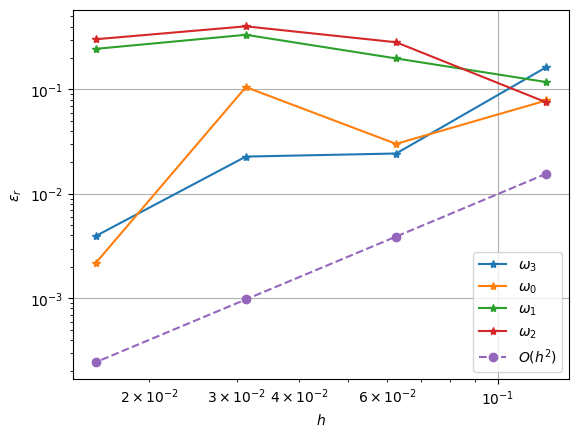

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P1_P0, "*-", label='$\omega_3$')
plt.plot(h_i, rel_error_eig_1_P1_P0, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_2_P1_P0, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_3_P1_P0, "*-", label='$\omega_2$')
plt.plot(
    h_i,
    [x**2 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{2}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
# plt.title(f"[P{problem.FE['p']._degree}-P{problem.FE['v']._degree}] - PML eigenvalues' convergence. {pml_type} profile.")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()

In [ ]:
print("P2-P1:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P2_P1[idx][-1]}")
    error = abs(groups_P2_P1[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P2-P1:
Autovalor 0:
  Exacto:      (12.566370614359172-2.197224577336219j)
  Aproximado:  (12.505715021031987-2.1770499073099323j)
  Error rel.:  0.0050107917810652

Autovalor 1:
  Exacto:      (25.132741228718345-2.197224577336219j)
  Aproximado:  (25.00314153792777-2.150181288619114j)
  Error rel.:  0.005464974411046216

Autovalor 2:
  Exacto:      (37.69911184307752-2.197224577336219j)
  Aproximado:  (25.00314153792777-2.150181288619114j)
  Error rel.:  0.33620283906892673

Autovalor 3:
  Exacto:      (50.26548245743669-2.197224577336219j)
  Aproximado:  (27.46630269678769-11.14703305573991j)
  Error rel.:  0.48680570218604186

Autovalor 4:
  Exacto:      (62.83185307179586-2.197224577336219j)
  Aproximado:  (32.70032587896437-11.632918717303339j)
  Error rel.:  0.5022148262174797



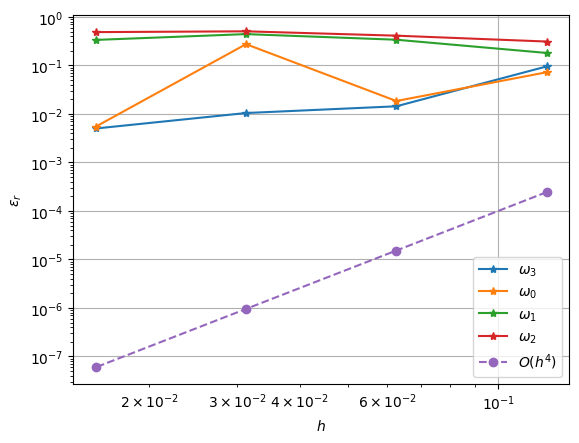

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P2_P1, "*-", label='$\omega_3$')
plt.plot(h_i, rel_error_eig_1_P2_P1, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_2_P2_P1, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_3_P2_P1, "*-", label='$\omega_2$')
plt.plot(
    h_i,
    [x**4 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{4}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()


In [ ]:
print("P3-P2:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P3_P2[idx][-1]}")
    error = abs(groups_P3_P2[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P3-P2:
Autovalor 0:
  Exacto:      (12.566370614359172-2.197224577336219j)
  Aproximado:  (12.505550894631737-2.177013204831258j)
  Error rel.:  0.005023907986663252

Autovalor 1:
  Exacto:      (25.132741228718345-2.197224577336219j)
  Aproximado:  (12.505550894631737-2.177013204831258j)
  Error rel.:  0.5005114961436595

Autovalor 2:
  Exacto:      (37.69911184307752-2.197224577336219j)
  Aproximado:  (25.003446302342965-2.1500859138148978j)
  Error rel.:  0.3361947780608315

Autovalor 3:
  Exacto:      (50.26548245743669-2.197224577336219j)
  Aproximado:  (25.003446302342965-2.1500859138148978j)
  Error rel.:  0.5020936511191343

Autovalor 4:
  Exacto:      (62.83185307179586-2.197224577336219j)
  Aproximado:  (25.003446302342965-2.1500859138148978j)
  Error rel.:  0.6016904703874608



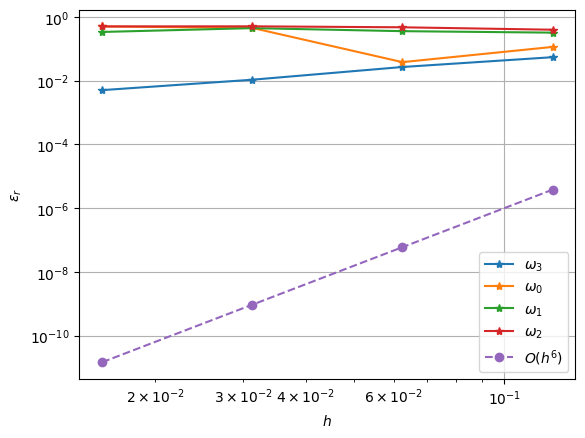

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P3_P2, "*-", label='$\omega_3$')
plt.plot(h_i, rel_error_eig_1_P3_P2, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_2_P3_P2, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_3_P3_P2, "*-", label='$\omega_2$')
plt.plot(
    h_i,
    [x**6 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{6}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()

In [ ]:
print("P4-P3:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P4_P3[idx][-1]}")
    error = abs(groups_P4_P3[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P4-P3:
Autovalor 0:
  Exacto:      (12.566370614359172-2.197224577336219j)
  Aproximado:  (12.505551850002908-2.1770148117177603j)
  Error rel.:  0.00502379719624665

Autovalor 1:
  Exacto:      (25.132741228718345-2.197224577336219j)
  Aproximado:  (12.505551850002908-2.1770148117177603j)
  Error rel.:  0.5005114581731936

Autovalor 2:
  Exacto:      (37.69911184307752-2.197224577336219j)
  Aproximado:  (25.00346041009741-2.150095176418902j)
  Error rel.:  0.33619440356695135

Autovalor 3:
  Exacto:      (50.26548245743669-2.197224577336219j)
  Aproximado:  (25.00346041009741-2.150095176418902j)
  Error rel.:  0.502093370379035

Autovalor 4:
  Exacto:      (62.83185307179586-2.197224577336219j)
  Aproximado:  (31.979844951437883-20.693810939020487j)
  Error rel.:  0.5721591771530999



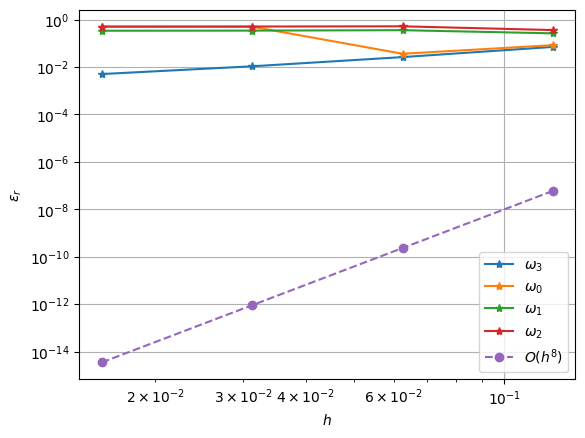

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P4_P3, "*-", label='$\omega_3$')
plt.plot(h_i, rel_error_eig_1_P4_P3, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_2_P4_P3, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_3_P4_P3, "*-", label='$\omega_2$')
plt.plot(
    h_i,
    [x**8 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{8}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()